In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, StratifiedShuffleSplit
from sklearn.metrics import average_precision_score, roc_auc_score
import numpy as np
from sklearn import tree
from deslib.des.knora_e import KNORAE
from sklearn.preprocessing import StandardScaler
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from smiles_only.data_utils import load_data_from_smiles
import torch

In [336]:
chembl = pd.read_csv('/home/dionizije/Documents/drug_attrition_oracle/data/chembl_4_smiles.csv', index_col=0)

In [40]:
chembl.loc[chembl['smiles'].str.contains('\.')]

,chembl_id,pubchem_cid,smiles,parent_smiles,chembl_tox,withdrawn
464,CHEMBL1237066,62859,O=C([O-])C(O)[C@H](O)[C@@H](O)[C@H](O)[C@H](O)...,O=C([O-])C(O)[C@H](O)[C@@H](O)[C@H](O)[C@H](O)...,Safe,0
700,CHEMBL2010412,452192,C[n+]1c2cc(N)ccc2cc2ccc(N)cc21.Nc1ccc2cc3ccc(N...,missing,Safe,0
842,CHEMBL1200747,62358,CC(O)C(=O)O.N,CC(O)C(=O)O.N,Safe,0
1376,CHEMBL2106975,61102,O=C([O-])O.[K+],O=C([O-])O.[K+],Safe,0
1409,CHEMBL1255943,2723891,Cl.N[C@@H](CCC(=O)O)C(=O)O,Cl.N[C@@H](CCC(=O)O)C(=O)O,Safe,0
...,...,...,...,...,...,...
10391,CHEMBL1200691,8896,CC(=O)[O-].CC(=O)[O-].[Mg+2],CC(=O)[O-].CC(=O)[O-].[Mg+2],Safe,0
10524,CHEMBL2106123,13136,O=C([O-])CC(O)(CC(=O)[O-])C(=O)[O-].O=C([O-])C...,O=C([O-])CC(O)(CC(=O)[O-])C(=O)[O-].O=C([O-])C...,Safe,0
10531,CHEMBL2364968,90661668,CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](NC(=...,missing,Safe,0
10560,CHEMBL261772,missing,C=C1c2c(Cl)ccc(O)c2C(=O)C2=C(O)[C@]3(O)C(=O)C(...,C=C1c2c(Cl)ccc(O)c2C(=O)C2=C(O)[C@]3(O)C(=O)C(...,Safe,0


In [338]:
chembl['smiles'].str.unique()

AttributeError: 'StringMethods' object has no attribute 'unique'

# Models

In [125]:
search_space = { # values for boostrap can be either True or False # values of max_depth are integers from 6 to 20
        "max_iter": Integer(10, 1000),
        "learning_rate": Real(0.001, 1),  
        "min_samples_leaf": Integer(1, 30)
    }

In [119]:
forest_clf = HistGradientBoostingClassifier(early_stopping=True, validation_fraction=0.15)

In [126]:
forest_bayes_search = BayesSearchCV(forest_clf, search_space, n_iter=32, # specify how many iterations
                                    scoring="roc_auc", n_jobs=-1, cv=5)

In [127]:
forest_bayes_search.fit(X, y)

BayesSearchCV(cv=5,
              estimator=HistGradientBoostingClassifier(early_stopping=True,
                                                       validation_fraction=0.15),
              n_iter=32, n_jobs=-1, scoring='roc_auc',
              search_spaces={'learning_rate': Real(low=0.001, high=1, prior='uniform', transform='identity'),
                             'max_iter': Integer(low=10, high=1000, prior='uniform', transform='identity'),
                             'min_samples_leaf': Integer(low=1, high=30, prior='uniform', transform='identity')})

In [128]:
forest_bayes_search.best_estimator_

HistGradientBoostingClassifier(early_stopping=True,
                               learning_rate=0.01619991660275452, max_iter=25,
                               min_samples_leaf=12, validation_fraction=0.15)

# AP

In [129]:
forest_bayes_search.best_score_

0.6878546912287747

# ROC auc

In [104]:
forest_bayes_search.best_score_

0.6895023895534506

In [79]:
aps = []
aucs = []
for train_index, test_index in skf.split(X, y):
    scaler = StandardScaler()
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    clf.fit(X_train, y_train)
    #knorae = KNORAE(pool_classifiers)
    #knorae.fit()
    log_probs = clf.predict_proba(X_test)[:, 1]
    ap = average_precision_score(y_test, log_probs)
    roc_auc = roc_auc_score(y_test, log_probs)
    aps.append(ap)
    aucs.append(roc_auc)

In [85]:
np.mean(aps)

0.14099473491817066

In [87]:
np.mean(aucs)

0.6449456398734204

# Knora

In [107]:
aps = []
aucs = []
for train_index, test_index in skf.split(X, y):
    scaler = StandardScaler()
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train, X_dsel, y_train, y_dsel = train_test_split(X_train, y_train, test_size=0.5)
    
    clf = forest_bayes_search.best_estimator_
    clf.fit(X_train, y_train)
    knorae = KNORAE(clf)
    knorae.fit(X_dsel, y_dsel)
    
    log_probs = clf.predict_proba(X_test)[:, 1]
    ap = average_precision_score(y_test, log_probs)
    roc_auc = roc_auc_score(y_test, log_probs)
    aps.append(ap)
    aucs.append(roc_auc)

In [110]:
np.mean(aps)

0.1549412394889774

In [111]:
np.mean(aucs)

0.6263718833458845

# GNN Explainer

In [25]:
from smiles_only.data_utils import smiles2graph
from torch_geometric.data import DataLoader, Data
from torch_geometric.nn import GNNExplainer
from typing import Dict, Optional
from smiles_only.EGConv import EGConvNet, AtomEncoder
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as pyplot
import networkx as nx

In [50]:
train = pd.read_csv('/home/dionizije/Documents/drug_attrition_oracle/data/chembl_train.csv', index_col=0)

In [51]:
train

,chembl_id,pubchem_cid,smiles,parent_smiles,chembl_tox,withdrawn
7833,CHEMBL710,57363,CC(C)(C)NC(=O)[C@H]1CC[C@H]2[C@@H]3CC[C@H]4NC(...,CC(C)(C)NC(=O)[C@H]1CC[C@H]2[C@@H]3CC[C@H]4NC(...,Safe,0
7511,CHEMBL1770248,44814423,CCOc1ccc(Cc2cc([C@]34OC[C@](CO)(O3)[C@@H](O)[C...,CCOc1ccc(Cc2cc([C@]34OC[C@](CO)(O3)[C@@H](O)[C...,Safe,0
6030,CHEMBL3989949,11962412,NC(=O)O[C@@H](Cn1ncnn1)c1ccccc1Cl,NC(=O)O[C@@H](Cn1ncnn1)c1ccccc1Cl,Safe,0
10493,CHEMBL844,2435,Brc1c(NC2=NCCN2)ccc2nccnc12,Brc1c(NC2=NCCN2)ccc2nccnc12,Safe,0
2262,CHEMBL833,5472,Clc1ccccc1CN1CCc2sccc2C1,Clc1ccccc1CN1CCc2sccc2C1,toxic_hema,0
...,...,...,...,...,...,...
8166,CHEMBL1201760,10178705,N[C@@H]1CCCCN(c2c(F)cc3c(=O)c(C(=O)O)cn(C4CC4)...,N[C@@H]1CCCCN(c2c(F)cc3c(=O)c(C(=O)O)cn(C4CC4)...,Safe,0
10183,CHEMBL1697782,63019,CCC(=O)O[C@]1(C(=O)COC(C)=O)CC[C@H]2[C@@H]3C[C...,CCC(=O)O[C@]1(C(=O)COC(C)=O)CC[C@H]2[C@@H]3C[C...,Safe,0
886,CHEMBL1480,3333,CCOC(=O)C1=C(C)NC(C)=C(C(=O)OC)C1c1cccc(Cl)c1Cl,CCOC(=O)C1=C(C)NC(C)=C(C(=O)OC)C1c1cccc(Cl)c1Cl,Safe,0
1950,CHEMBL3545432,56844015,CC(C)C[C@H](NC(=O)CNC(=O)c1cc(Cl)ccc1Cl)B1OC(=...,CC(C)C[C@H](NC(=O)CNC(=O)c1cc(Cl)ccc1Cl)B1OC(=...,Safe,0


In [45]:
test = pd.read_csv('/home/dionizije/Documents/drug_attrition_oracle/data/chembl_test.csv', index_col=0)

In [52]:
test['withdrawn'].value_counts(normalize=True)

0    0.929231
1    0.070769
Name: withdrawn, dtype: float64

In [7]:
test_data_list = []
for index, row in test.iterrows():
    test_data_list.append(smiles2graph(row, 'withdrawn'))

In [8]:
test_data_list[13].x.size()

torch.Size([29, 27])

In [15]:
model = EGConvNet(512, 7, 2, 4, aggregator=['sum', 'mean', 'max'])

In [16]:
state_dict = torch.load('/home/dionizije/epoch=36-step=3625.ckpt', map_location=torch.device('cpu'))['state_dict']

In [17]:
for _ in range(len(state_dict)):
    k, v = state_dict.popitem(False)
    k = k.split('model.')[1]
    state_dict[k] = v

In [18]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [19]:
model.eval()

EGConvNet(
  (lin1): Linear(in_features=27, out_features=512, bias=True)
  (norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convs): ModuleList(
    (0): EGConv(512, 512, aggregators=['sum', 'mean', 'max'])
    (1): EGConv(512, 512, aggregators=['sum', 'mean', 'max'])
    (2): EGConv(512, 512, aggregators=['sum', 'mean', 'max'])
    (3): EGConv(512, 512, aggregators=['sum', 'mean', 'max'])
    (4): EGConv(512, 512, aggregators=['sum', 'mean', 'max'])
    (5): EGConv(512, 512, aggregators=['sum', 'mean', 'max'])
    (6): EGConv(512, 512, aggregators=['sum', 'mean', 'max'])
  )
  (norms): ModuleList(
    (0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [36]:
def explain_molecule(data, epochs):
    explainer = GNNExplainer(model, epochs=epochs)
    node_feat_mask, edge_mask = explainer.explain_graph(data.x, data.edge_index)
    print(node_feat_mask)
    edge_mask = edge_mask.detach().numpy()
    edge_mask = edge_mask / edge_mask.max()
    viridis = pyplot.cm.get_cmap('YlOrRd')
    color_map = []
    for i in edge_mask:
        color = viridis(i)
        color_map.append(color)
    #edge_mask = np.where(edge_mask > 0.80, 1, 0)
    viridis = pyplot.cm.get_cmap('YlOrRd')
    graph = Data(x=data.x, edge_index=data.edge_index, edge_attrs=color_map) 
    g = to_networkx(graph, to_undirected=True, edge_attrs=['edge_attrs'])
    pos = nx.planar_layout(g)
    pos = nx.spring_layout(g, pos=pos)
    widths = [x * 10 for x in edge_mask]
    nx.draw(g, pos=pos, width=widths,edge_color=color_map)

Explain graph: 100%|██████████| 50/50 [00:03<00:00, 12.98it/s]


tensor([0.4015, 0.4401, 0.3781, 0.5820, 0.3592, 0.3665, 0.3601, 0.3905, 0.3603,
        0.3386, 0.3446, 0.4182, 0.6427, 0.4095, 0.4021, 0.3925, 0.3907, 0.3901,
        0.6092, 0.6097, 0.4101, 0.4042, 0.3963, 0.5981, 0.3489, 0.3975, 0.3738])


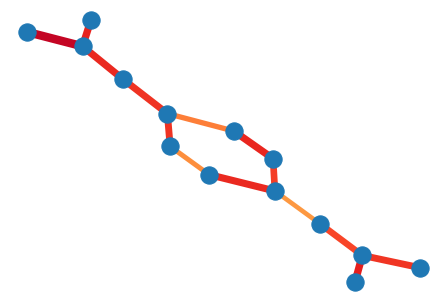

In [38]:
explain_molecule(test_data_list[2], epochs=50)

In [152]:
from standardiser import standardise
from tqdm import tqdm
from rdkit.Chem.Scaffolds.MurckoScaffold import MakeScaffoldGeneric
from rdkit.Chem import MolToSmiles, MolFromSmiles

In [155]:
data = pd.read_csv('/home/dionizije/Documents/drug_attrition_oracle/data/chembl_4_smiles.csv', index_col=0)

In [157]:
standardised_mols = []
scaffolds = []
scaffolds_generic = []
for i in data['smiles']:
    try:
        new_mol = standardise.run(i)
        standardised_mols.append(new_mol)
        scaffolds_generic.append(MolToSmiles(MakeScaffoldGeneric(MolFromSmiles(new_mol))))
    except Exception as e:
        print(e)
        scaffolds_generic.append(0)
        standardised_mols.append(0)

No non-salt/solvate components
No non-salt/solvate components
Multiple non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
Multiple non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
Multiple non-salt/solvate components
Multiple non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
Multiple non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
Multiple non-salt/solvate components


RDKit ERROR: [11:14:53] Can't kekulize mol.  Unkekulized atoms: 3 10
RDKit ERROR: 


No non-salt/solvate components
Multiple non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
Multiple non-salt/solvate components
No non-salt/solvate components


RDKit ERROR: [11:14:55] Can't kekulize mol.  Unkekulized atoms: 0 2 4 6 7 9
RDKit ERROR: 


No non-salt/solvate components
No non-salt/solvate components
Multiple non-salt/solvate components
Multiple non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
Multiple non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
Multiple non-salt/solvate components
Multiple non-salt/solvate components
Multiple non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
Multiple non-salt/solvate components
Multiple non-salt/solvate components
Multiple non-salt/solvate components
Multiple non-salt/solvate components
Multiple non-salt/solvate components
Multiple non-salt/solvate components
Multiple non-salt/solvate components
No non-salt/solvate components
No non-salt/solvate components
Multiple non-salt/solvate components
No non-salt/solva

In [158]:
data['generic_scaffolds'] = scaffolds_generic
data['standardised_smiles'] = standardised_mols

# All atom types are C and all bonds are single

In [ ]:
DS_three_classes_DrugBank_referent_29July2021_sums.csv

In [515]:
data = pd.read_csv('/home/dionizije/Documents/drug_attrition_oracle/data/processing_pipeline/alldata_min_phase_4_standardized.csv', index_col=0)

In [483]:
withdrawn = pd.read_csv('/home/dionizije/Documents/drug_attrition_oracle/data/raw/withdrawn.csv', index_col=0)